# Consistent Character Designs For Storyboards

In this hands-on session, we'll explore how to use the Nova Canvas text-to-image capabilities to create consistent character designs for storyboards and visual development.

## Use Case

OctankStudio, a fictional animation studio, would like to leverage AI image generation to streamline their character design and storyboarding process. Specifically, they need to:

1. Establish a consistent visual style and character design for the protagonist in their upcoming animated short film.
2. Ensure the character maintains a cohesive look and feel across all the generated images.

## Workshop Objectives

By the end of this workshop, you will:

1. Understand how to use text prompts with the Nova Canvas model to generate consistent character designs.
2. Learn techniques for controlling the visual style, proportions, and other attributes of generated characters.
3. Gain hands-on experience using the Amazon Bedrock API to create a library of character images for storyboarding.

To begin, run the cell below to set up the necessary dependencies and create instances of the Bedrock clients we'll use throughout this workshop.


In [ ]:
%pip install -r requirements.txt

## Introduction to Text-To-Image

The simplest way to use the model is to generate images based on a text description. In Nova Canvas, this mode of generation is identified with a `taskType` of "TEXT_IMAGE". In this notebook, you'll explore a few of the parameters supported by the "TEXT_IMAGE" task type.

To begin, run the cell below to create an instance of the Bedrock Runtime client. We'll use this to call the model later.

<div class="alert alert-block alert-warning">
<strong>⚠️ Important:</strong> Note that we configure the client to use a longer read timeout of 5 minutes. This is a best practice when working with Nova Canvas because, depending on the parameters you configure and the number of images you request, processing can take longer than the AWS SDK default timeout of 60 seconds.
</div>


In [4]:
import io
import os
import json
import base64
import boto3
from botocore.config import Config
from PIL import Image
from helpers.image_utils import save_image, plot_images_for_comparison

bedrock_runtime_client = boto3.client(
    "bedrock-runtime",
    region_name="us-east-1",
    config=Config(
        read_timeout=5 * 60
    ),  # IMPORTANT: Increase the read timeout to 5 minutes to support longer operations.
)
image_generation_model_id = "amazon.nova-canvas-v1:0"
output_dir = "output"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print("Output directory created.")
else:
    print("Output directory already exists.")

Output directory created.


### Example 1 - Creating images using text prompts

In this section, you'll explore prompt engineering techniques for designing a character.

First, let's create a helper function to generate images with different seed values using the Amazon Bedrock `invoke_model` API.  In the following exercises, we will use this function to explore how changing the `seed` and `cfgScale` value API parameters changes the images generated by Nova Canvas.

In [2]:
def generate_images(text, seed_values = [57], cfg_scale_values = [6.5]):
    """Generate images using the Amazon Nova Canvas text-to-image model.

    Args:
        text (str): The text prompt to use for image generation.
        cfgScale (float, optional): The configuration scale to use for image generation. Controls how closely the generated images match the prompt. Defaults to 6.5.
        seed_values list of int: The random seed to use for image generation. 

    Returns:
        list: A list of generated images as PIL.Image objects.
    """
    generated_images = []

    # Generate image using only a text prompt.
    for index, seed in enumerate(seed_values):
        for index, cfg_scale in enumerate(cfg_scale_values):
            body = json.dumps(
                {
                    "taskType": "TEXT_IMAGE",
                    "textToImageParams": {"text": text},
                    "imageGenerationConfig": {
                        "numberOfImages": 1,  # Number of images to generate, up to 5
                        "width": 1024,
                        "height": 1024,
                        "cfgScale": cfg_scale,  # How closely the prompt will be followed
                        "seed": seed,  # Any number from 0 through 858,993,459
                        "quality": "premium",  # Quality of either "standard" or "premium"
                    },
                }
            )
    
            print(f"Generating image {index + 1} of {len(seed_values)}...")
        
            response = bedrock_runtime_client.invoke_model(
                body=body,
                modelId=image_generation_model_id,
                accept="application/json",
                contentType="application/json",
            )
        
            response_body = json.loads(response.get("body").read())
        
            base64_images = response_body.get("images")
            image_path = f"{output_dir}/01-text-to-image_seed-{seed}-cfg_scale-{cfg_scale}.png"
            save_image(base64_images[0], image_path)
        
            print(f"Saved to {image_path}")
        
            generated_img = [
                Image.open(io.BytesIO(base64.b64decode(base64_image)))
                for base64_image in base64_images
            ]
            generated_images.append(generated_img[0])

    return generated_images



Prompting for image generation models differs from prompting for large language models (LLMs). Image generation models do not have the ability to reason or interpret explicit commands. Therefore, it's best to phrase your prompt as if it were an image caption rather than a command or conversation. You might want to include details about the subject, action, environment, lighting, style, and camera position.

Let's start developing our character by creating a simple description of Mayu:

> A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform.





Generating image 1 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-6.5.png
Prompt: A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform.



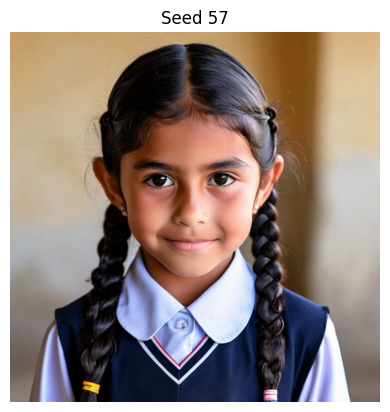

In [5]:
character_description = "A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform."
text = f"{character_description}"
seed_values = [57]  # Any number from 0 through 858,993,459
generated_images = generate_images(text, seed_values)

# Plot comparison images
plot_images_for_comparison(
    generated_images=generated_images,
    labels=seed_values,
    prompt=text,
    comparison_mode=True,
    title_prefix="Seed",
)

### Example 2 - Adding visual style to a character

An effective prompt often includes short descriptions of the subject and the environment.  Optionally, you can add information to control the composition and visual style for images.  

For storyboarding, the composition elements such as camera position, pose, and lighting will vary from scene to scene, but the style will be one of the unifying elements that can help create consistency across scenes.

In the section below, you'll define several visual styles.  To adhere to prompt engineering best practice of keeping the most important details at the beginning of a prompt, the style information is separated into two parts.  The `description` is the main visual style class and medium.  The `details` is more supporting details about the characteristics of the style.  When we build our prompts the description will go at the beginning and the `details` will be placed at the end.


In [6]:
styles = [
    {
        "name": "graphic-novel",
        "description": "A graphic novel style illustation of",
        "details": "Bold linework, dramatic shadows, and flat color palettes. Use high contrast lighting and cinematic composition typical of comic book panels. Include expressive line work to convey emotion and movement.",
    },
    {
        "name": "sketch",
        "description": "A simple black and white line sketch of",
        "details": "Rough, sketch-like lines create a storyboard aesthetic. High contrast. No color",
    },
    {
        "name": "digital-illustration",
        "description": "A 3D digital drawing of",
        "details": "High contrast. Rounded character design. Smooth rendering. Soft texture. Luminous lighting",
    },
]

# Create enum for meaningful index names
GRAPHIC_NOVEL = 0
SKETCH = 1
DIGITAL_ILLUSTRATION = 2

Now, let's generate some images of Mayu using the different styles by constructing a prompt with the following elements:

> style description + character description + style details

Generating image 1 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-6.5.png
Generating image 1 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-6.5.png
Generating image 1 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-6.5.png
Prompt: A 3D digital drawing of A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform. High contrast. Rounded character design. Smooth rendering. Soft texture. Luminous lighting



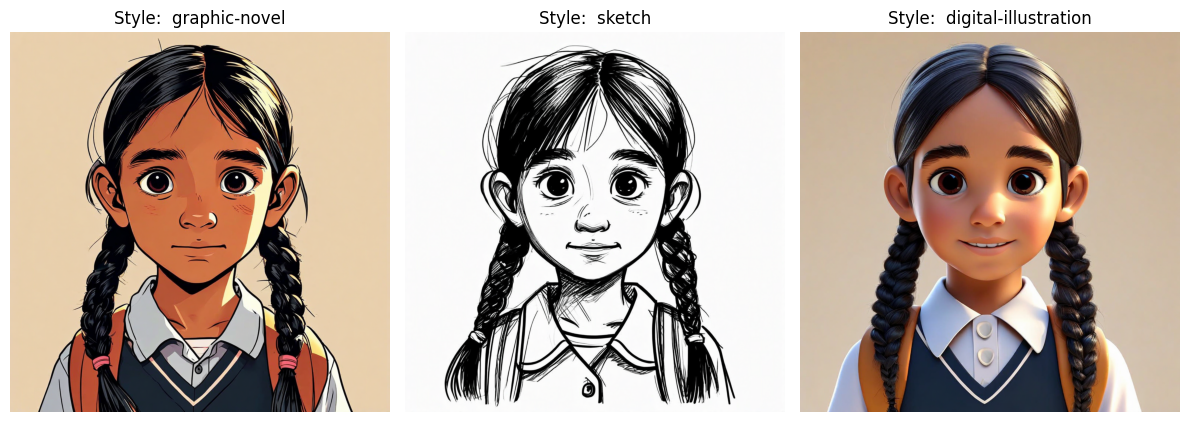

In [7]:
character_description = "A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform."

generated_images = []
for style in styles:

    text = f"{style["description"]} {character_description} {style["details"]}"
    seed_values = [57]  # Any number from 0 through 858,993,459
    generated_images.extend(generate_images(text, seed_values))

labels = [style["name"] for style in styles]

# Plot comparison images
plot_images_for_comparison(
    generated_images=generated_images,
    labels=labels,
    prompt=text,
    comparison_mode=True,
    title_prefix="Style: ",
)

### Example 3: Developing character variations using seeds

When the output you get from a prompt is close to what you want but not quite perfect, try the following techniques one at a time in turn to refine your result:

- Using a consistent seed value, make small changes to your prompt or negative prompt and re-run the prompt. This allows you to better understand how your prompt wording affects the output, allowing you to iteratively improve your results in a controlled way.

- Once the prompt has been refined to your liking, generate more variations using the same prompt but a different seed value. It is often useful to generate multiple variations of an image by running the sample prompt with different seeds in order to find that perfect output image.

We want to generate a few designs that we can choose from. The `seed` parameter can help with this.

The `seed` parameter provides a way to introduce randomness into the output for a given text prompt. Using different seed values while leaving the text prompt unchanged will produce images that all adhere to the prompt but vary in their visual appearance. For this reason, `seed` can be an useful way to produce many variations based on a single text prompt.

Let's see how different seed values can impact the results. Run the cells below. The generated images will be saved to the "output" folder.


Generating image 1 of 5...
Saved to output/01-text-to-image_seed-1-cfg_scale-6.5.png
Generating image 1 of 5...
Saved to output/01-text-to-image_seed-20-cfg_scale-6.5.png
Generating image 1 of 5...
Saved to output/01-text-to-image_seed-57-cfg_scale-6.5.png
Generating image 1 of 5...
Saved to output/01-text-to-image_seed-139-cfg_scale-6.5.png
Generating image 1 of 5...
Saved to output/01-text-to-image_seed-12222-cfg_scale-6.5.png
Prompt: A graphic novel style illustation of A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform. Bold linework, dramatic shadows, and flat color palettes. Use high contrast lighting and cinematic composition typical of comic book panels. Include expressive line work to convey emotion and movement.



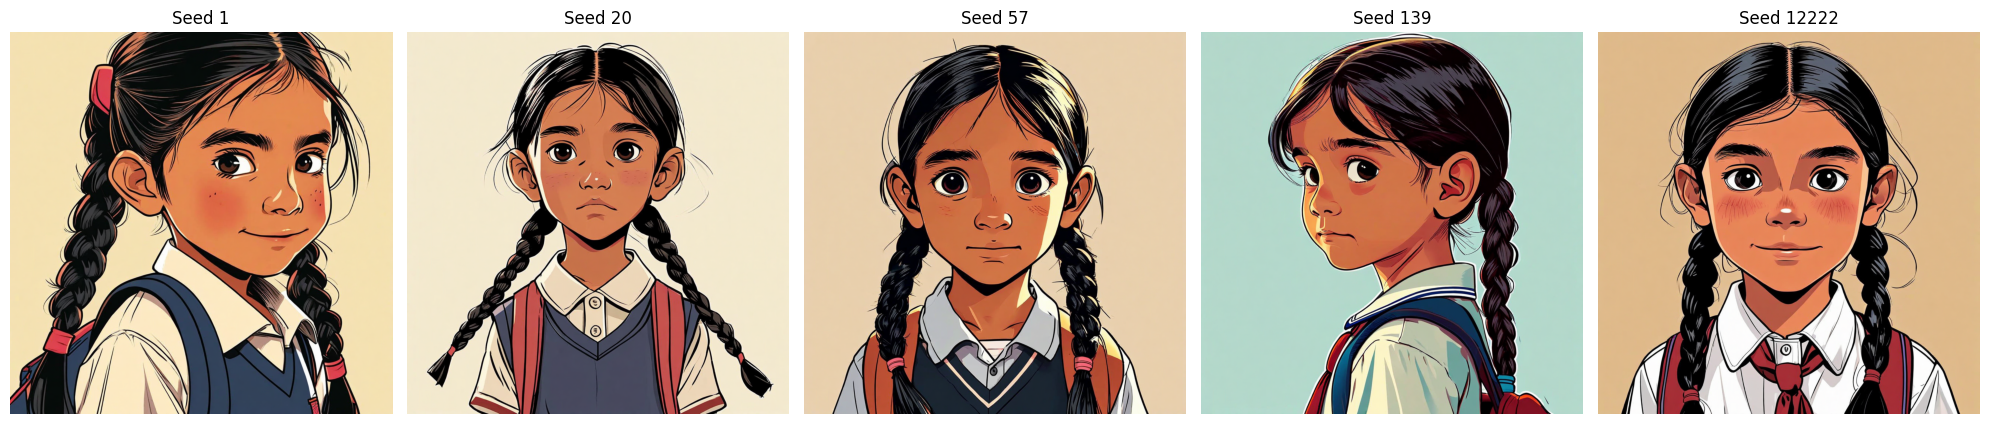

In [8]:
# Define the main input parameters.
character_description = "A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform."
style = styles[GRAPHIC_NOVEL]
text = f"{style["description"]} {character_description} {style["details"]}"
seed_values = [1, 20, 57, 139, 12222]  # Any number from 0 through 858,993,459
generated_images = generate_images(text, seed_values)

# Plot comparison images
plot_images_for_comparison(
    generated_images=generated_images,
    labels=seed_values,
    prompt=text,
    comparison_mode=True,
    title_prefix="Seed",
)

<div class="alert alert-block alert-info">
<strong>💡 Bonus Activity:</strong> Try different seeds to generate a different set of variations. 
</div>


<div class="alert alert-block alert-info">
<strong>💡 Bonus Activity:</strong> Try different styles to generate a different set of variations. 
</div>

### Example 4: Developing character variations using the "cfgScale" parameter

The `cfgScale` parameter controls how closely your prompt will be followed. In this example, we are going to generate images using different values for `cfgScale` to see their effect.

`cfgScale` may be set to min 1.1 up to a max of 10. Lower values give the model more freedom to interpret your prompt loosely. Higher values are more faithful to your prompt, but setting the value too high can result in over-emphasis of some things mentioned in your prompt. The default is 6.5 and is a good starting point.

Run the cells below. The generated images will be saved to the "output" folder. Note how a value of 10 (the maximum) results in over-emphasis of the "skate shop" part of the prompt, adding wheels to everything!


In [9]:
# Define the main input parameters.
character_description = "A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform."
style = styles[GRAPHIC_NOVEL]
text = f"{style["description"]} {character_description} {style["details"]}"
cfg_scale_values = [1.1, 3.5, 6.5, 8.0, 10]
seed_values = [57]

Generating image 1 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-1.1.png
Generating image 2 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-3.5.png
Generating image 3 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-6.5.png
Generating image 4 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-8.0.png
Generating image 5 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-10.png
Prompt: A graphic novel style illustation of A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform. Bold linework, dramatic shadows, and flat color palettes. Use high contrast lighting and cinematic composition typical of comic book panels. Include expressive line work to convey emotion and movement.



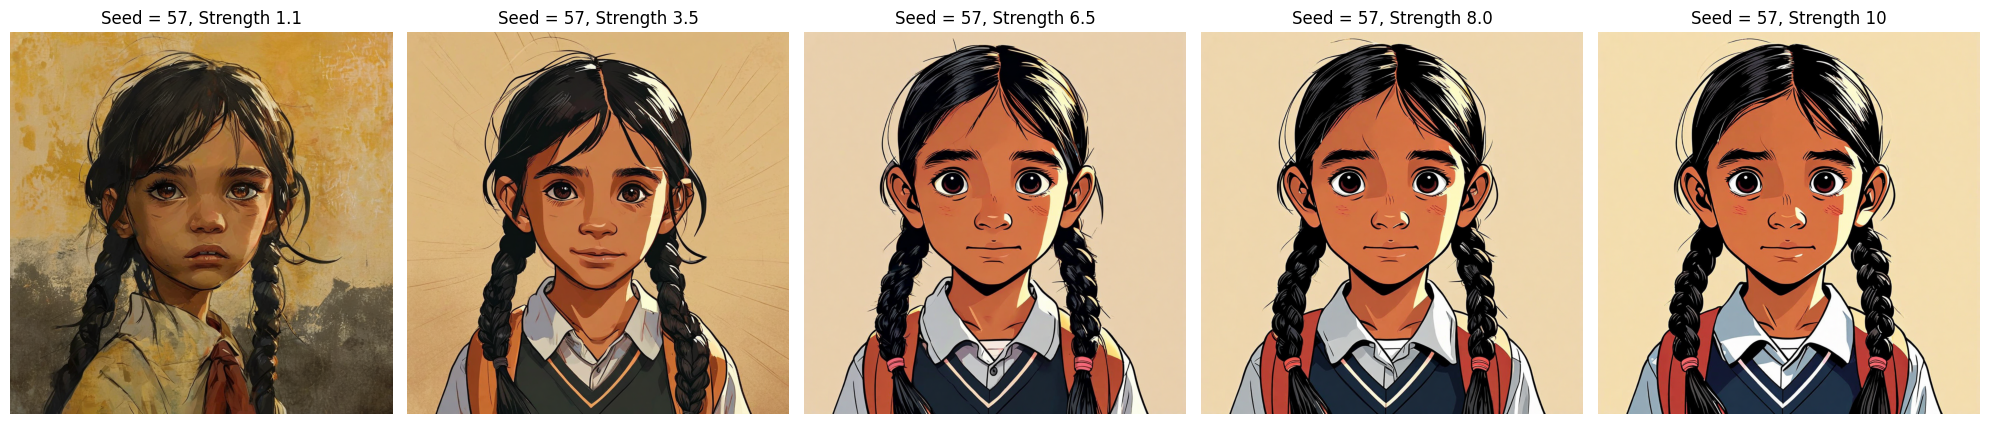

In [12]:

generated_images = generate_images(text, seed_values, cfg_scale_values)

# Plot comparison images
plot_images_for_comparison(
    generated_images=generated_images,
    labels=cfg_scale_values,
    prompt=text,
    comparison_mode=True,
    title_prefix=f"Seed = {seed_values[0]}, Strength",
)

### Example 5: Using our character in a story

Now that you have a feel for some of the tools that can be used to engineer prompts with consistent images, let's try featuring the characters a few different scenes.  In order to achieve consistency, we will need to include consistent settings for the style, seed, cfgScale and character description in the Nova Canvas prompt for each scene. 


In [13]:
scenes = [
    "ridng a bike on a mountain pass",
    "walking on a path through tall grass in the Andes",
    "eating ice cream at the beach"
]

Generating image 1 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-6.5.png
Prompt: A graphic novel style illustation of A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform. ridng a bike on a mountain pass Bold linework, dramatic shadows, and flat color palettes. Use high contrast lighting and cinematic composition typical of comic book panels. Include expressive line work to convey emotion and movement.



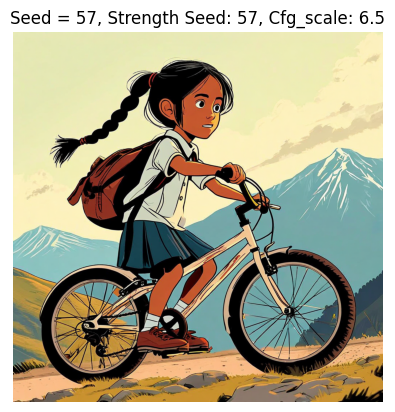

Generating image 1 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-6.5.png
Prompt: A graphic novel style illustation of A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform. walking on a path through tall grass in the Andes Bold linework, dramatic shadows, and flat color palettes. Use high contrast lighting and cinematic composition typical of comic book panels. Include expressive line work to convey emotion and movement.



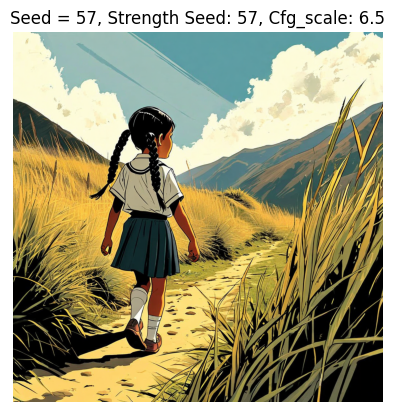

Generating image 1 of 1...
Saved to output/01-text-to-image_seed-57-cfg_scale-6.5.png
Prompt: A graphic novel style illustation of A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform. eating ice cream at the beach Bold linework, dramatic shadows, and flat color palettes. Use high contrast lighting and cinematic composition typical of comic book panels. Include expressive line work to convey emotion and movement.



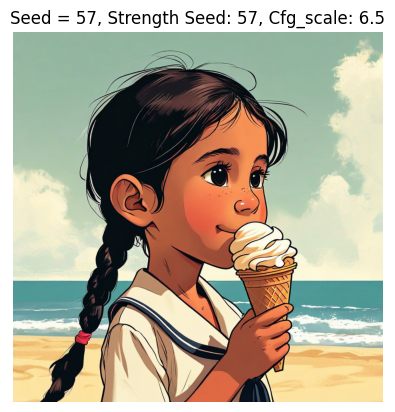

In [14]:
# Define the main input parameters.
character_description = "A 7 year old peruvian girl with dark hair in two low braids wearing a school uniform."
style = styles[GRAPHIC_NOVEL]
cfg_scale_values = [6.5]
seed_values = [57]

for scene in scenes:
    text = f"{style["description"]} {character_description} {scene} {style["details"]}"
    generated_images = generate_images(text, seed_values, cfg_scale_values)

    # Plot comparison images
    plot_images_for_comparison(
        generated_images=generated_images,
        labels=[f"Seed: {seed}, Cfg_scale: {cfg}" for seed in seed_values for cfg in cfg_scale_values],
        prompt=text,
        comparison_mode=True,
        title_prefix=f"Seed = {seed_values[0]}, Strength",
    )

<div class="alert alert-block alert-info">
<strong>💡 Bonus Activity:</strong> Try different styles, seeds and cfg_scale to generate a different set of variations. 
</div>

## Take Away

Text-to-image generation is a powerful feature that empowers users to create visual content from textual descriptions. By simply writing descriptive text prompts, individuals can generate unique and diverse images that match their vision. This innovative tool has wide-ranging applications, from conceptual art and storyboarding to rapid prototyping and visual brainstorming. Whether you're an artist seeking inspiration, a marketer creating promotional materials, or a game developer designing characters, the text-to-image feature of Nova Canvas offers an efficient and accessible way to bring ideas to life visually.

Continue to the next section to learn about creating an end-to-end prompt flow for creating image and video storyboards using a consistent character design.
